# Project Velocity Discussion Notebook


Project Velocity is defined in chaoss here: https://chaoss.community/kb/metric-project-velocity/ 

Discussed in the context of CNCF: https://www.cncf.io/blog/2017/06/05/30-highest-velocity-open-source-projects/

In the general case the graph axises are definied as: <br>
- X-Axis: Logarithmic scale for Code Changes
- Y-Axis: Logarithmic scale of Sum of Number of Issues and Number of Review
- Dot-size: Committers (we are using distinct contributors)
- Dots are project

Hover values from CNCF viz: <br>
- Project Name 
- Num of Commits 
- Project Commit Authors
- Size (square root of authors)

This notebook does all of the preprocessing down to the visualization for we can try different strategies before putting it into 8Knot

In [3]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import plotly.express as px
import datetime as dt
import plotly
import math

with open("../../copy_cage-padres.json") as config_file:
    config = json.load(config_file)

In [4]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

CNCF incubating projects to demo these visualizations on

In [34]:
cncf_incubating = [
    'https://github.com/cloud-custodian/cloud-custodian',
    'https://github.com/kubeedge/kubeedge',
    'https://github.com/dragonflyoss/Dragonfly2',
    'https://github.com/cert-manager/cert-manager',
    'https://github.com/falcosecurity/falco',
    'https://github.com/in-toto/in-toto',
    'https://github.com/kyverno/kyverno',
    'https://github.com/notaryproject/notary',
    'https://github.com/keycloak/keycloak',
    'https://github.com/cubeFS/cubefs',
    'https://github.com/longhorn/longhorn',
    'https://github.com/cri-o/cri-o',
    'https://github.com/cilium/cilium',
    'https://github.com/containernetworking/cni',
    'https://github.com/crossplane/crossplane',
    'https://github.com/volcano-sh/volcano',
    'https://github.com/grpc/grpc',
    'https://github.com/projectcontour/contour',
    'https://github.com/emissary-ingress/emissary',
    'https://github.com/istio/istio',
    'https://github.com/cloudevents/spec',
    'https://github.com/nats-io/nats-server',
    'https://github.com/backstage/backstage',
    'https://github.com/buildpacks/pack',
    'https://github.com/kubevela/kubevela',
    'https://github.com/kubevirt/kubevirt',
    'https://github.com/operator-framework/operator-sdk',
    'https://github.com/keptn/keptn',
    'https://github.com/openkruise/kruise',
    'https://github.com/dapr/dapr',
    'https://github.com/kedacore/keda',
    'https://github.com/knative/community',
    'https://github.com/cortexproject/cortex',
    'https://github.com/OpenObservability/OpenMetrics',
    'https://github.com/thanos-io/thanos',
    'https://github.com/open-telemetry/community',
    'https://github.com/chaos-mesh/chaos-mesh',
    'https://github.com/litmuschaos/litmus'
] 

Get repo_ids for augur data access 

In [35]:
url_query = str(cncf_incubating)
url_query = url_query[1:-1]

repo_query = salc.sql.text(f"""
        SET SCHEMA 'augur_data';
        SELECT DISTINCT
            r.repo_id,
            r.repo_name
        FROM
            repo r
        JOIN repo_groups rg 
        ON r.repo_group_id = rg.repo_group_id
        WHERE
            r.repo_git in({url_query})
        """)

t = engine.execute(repo_query)
results = t.all()
repo_ids = [ row[0] for row in results]
repo_names = [ row[1] for row in results]
print(repo_ids)
print(repo_names)

[28171, 30921, 31361, 34175, 34796, 61162, 61180, 61187, 61200, 61275, 61496, 62108, 62191, 63946, 64742, 64743, 64744, 64751, 64759, 64762, 64764, 64768, 64779, 64876, 65503, 73289, 73297, 73299, 73303, 73310, 73311, 73314, 73315, 73318, 73329]
['cri-o', 'keycloak', 'spec', 'keda', 'community', 'backstage', 'thanos', 'kubeedge', 'keptn', 'istio', 'operator-sdk', 'falco', 'cert-manager', 'community', 'pack', 'cilium', 'dapr', 'in-toto', 'kyverno', 'litmus', 'nats-server', 'kruise', 'volcano', 'kubevirt', 'crossplane', 'longhorn', 'chaos-mesh', 'kubevela', 'cni', 'cloud-custodian', 'cortex', 'contour', 'emissary', 'grpc', 'notary']


Query for contributions with related contributor information. This query gets the following contributor actions: 
- Commits 
- Issues: open, close, comment 
- Pull Requests: open, close, merge, review, comment


In [36]:
repo_statement = str(repo_ids)
repo_statement = repo_statement[1:-1]
print(repo_statement)

contrib_query = salc.sql.text(f"""
                SELECT
                        repo_id as id,
                        repo_name,
                        cntrb_id,
                        created_at,
                        login,
                        action,
                        rank
                    FROM
                        augur_data.explorer_contributor_actions
                    WHERE
                        repo_id in({repo_statement})
                """)
df = pd.read_sql(contrib_query, con=engine)

df = df.reset_index()
df.drop("index", axis=1, inplace=True)

28171, 30921, 31361, 34175, 34796, 61162, 61180, 61187, 61200, 61275, 61496, 62108, 62191, 63946, 64742, 64743, 64744, 64751, 64759, 64762, 64764, 64768, 64779, 64876, 65503, 73289, 73297, 73299, 73303, 73310, 73311, 73314, 73315, 73318, 73329


In [37]:
df

,id,repo_name,cntrb_id,created_at,login,action,rank
0,34175,keda,010319e7-7d00-0000-0000-000000000000,2023-08-01 11:20:30-05:00,jmalvarezf-lmes,pull_request_comment,19
1,34175,keda,01000b15-fb00-0000-0000-000000000000,2023-08-01 10:15:34-05:00,zroubalik,pull_request_merged,5132
2,34175,keda,01023309-9a00-0000-0000-000000000000,2023-08-01 09:44:52-05:00,JorTurFer,issue_closed,4237
3,34175,keda,01085356-0600-0000-0000-000000000000,2023-08-01 09:39:55-05:00,JorTurFer,issue_comment,13
4,34175,keda,01085356-0600-0000-0000-000000000000,2023-08-01 09:28:14-05:00,matan-legit,issue_closed,12
...,...,...,...,...,...,...,...
1622432,64764,nats-server,0100015f-f100-0000-0000-000000000000,2012-10-30 12:18:39-05:00,derekcollison,commit,6
1622433,64764,nats-server,0100015f-f100-0000-0000-000000000000,2012-10-30 12:16:59-05:00,derekcollison,commit,5
1622434,64764,nats-server,0100015f-f100-0000-0000-000000000000,2012-10-30 12:16:37-05:00,derekcollison,commit,4
1622435,64764,nats-server,0100015f-f100-0000-0000-000000000000,2012-10-29 22:20:33-05:00,derekcollison,commit,2


df_cntrbs holds values for number of unique contributors in each repo

In [62]:
df_cntrbs = pd.DataFrame(df.groupby('repo_name')['cntrb_id'].nunique()).rename(columns={"cntrb_id": "num_unique_contributors"})
df_cntrbs.head()

,num_unique_contributors
repo_name,
backstage,1691
cert-manager,2617
chaos-mesh,562
cilium,1885
cloud-custodian,1335


df_actions holds a transformed version of the df to have the actions as columns, repo_name as the index, and the row values as the corresponding counts 

In [39]:
# group actions and repos to get the counts of the actions by repo 
df_actions = pd.DataFrame(df.groupby('repo_name')['action'].value_counts())
df_actions = df_actions.rename(columns={"action": "count"}).reset_index()
# pivot df to reformat the actions to be columns and repo_id to be rows 
df_actions = df_actions.pivot(index="repo_name", columns="action", values="count")

In [63]:
df_actions.head()

action,commit,issue_closed,issue_comment,issue_opened,pull_request_closed,pull_request_comment,pull_request_merged,pull_request_open,pull_request_review_APPROVED,pull_request_review_CHANGES_REQUESTED,pull_request_review_COMMENTED,pull_request_review_DISMISSED
repo_name,,,,,,,,,,,,
backstage,40388.0,NaN,NaN,NaN,677.0,16923.0,2582.0,13657.0,15952.0,952.0,21202.0,109.0
cert-manager,7746.0,1159.0,13435.0,3055.0,186.0,15011.0,767.0,2981.0,990.0,346.0,5259.0,8.0
chaos-mesh,1717.0,671.0,3558.0,1484.0,155.0,13276.0,1058.0,2467.0,4138.0,167.0,4666.0,348.0
cilium,23203.0,1222.0,5772.0,7964.0,672.0,23435.0,2601.0,19134.0,32446.0,5307.0,36805.0,419.0
cloud-custodian,4299.0,1773.0,6222.0,3813.0,523.0,7146.0,2283.0,4662.0,2852.0,144.0,7447.0,53.0


df_consolidated combines the actions and unique contributors and then specific columns for visualization use are added on 

In [64]:
df_consolidated = pd.concat([df_actions, df_cntrbs], axis=1).reset_index()

In [66]:
df_consolidated.head()

,repo_name,commit,issue_closed,issue_comment,issue_opened,pull_request_closed,pull_request_comment,pull_request_merged,pull_request_open,pull_request_review_APPROVED,pull_request_review_CHANGES_REQUESTED,pull_request_review_COMMENTED,pull_request_review_DISMISSED,num_unique_contributors
0,backstage,40388.0,NaN,NaN,NaN,677.0,16923.0,2582.0,13657.0,15952.0,952.0,21202.0,109.0,1691
1,cert-manager,7746.0,1159.0,13435.0,3055.0,186.0,15011.0,767.0,2981.0,990.0,346.0,5259.0,8.0,2617
2,chaos-mesh,1717.0,671.0,3558.0,1484.0,155.0,13276.0,1058.0,2467.0,4138.0,167.0,4666.0,348.0,562
3,cilium,23203.0,1222.0,5772.0,7964.0,672.0,23435.0,2601.0,19134.0,32446.0,5307.0,36805.0,419.0,1885
4,cloud-custodian,4299.0,1773.0,6222.0,3813.0,523.0,7146.0,2283.0,4662.0,2852.0,144.0,7447.0,53.0,1335


## Part where discussion is needed 

The x and y axis are the atributes that we need to decide on. Choass defines them as the following:
- X-Axis: Logarithmic scale for Code Changes
- Y-Axis: Logarithmic scale of Sum of Number of Issues and Number of Reviews

With the data we have lets figure out what the best aplication is for the most informative visualization 

In [42]:
df_consolidated["prs_opened+issues_closed"] = df_consolidated["issue_closed"] + df_consolidated["pull_request_open"]
df_consolidated["log_prs_o+issues_c"] = df_consolidated["prs_opened+issues_closed"].apply(math.log)
df_consolidated["log_num_commits"] = df_consolidated["commit"].apply(math.log)
df_consolidated["log_num_contrib"] = df_consolidated["num_unique_contributors"].apply(math.log)

In [67]:
df_consolidated.head()

,repo_name,commit,issue_closed,issue_comment,issue_opened,pull_request_closed,pull_request_comment,pull_request_merged,pull_request_open,pull_request_review_APPROVED,pull_request_review_CHANGES_REQUESTED,pull_request_review_COMMENTED,pull_request_review_DISMISSED,num_unique_contributors
0,backstage,40388.0,NaN,NaN,NaN,677.0,16923.0,2582.0,13657.0,15952.0,952.0,21202.0,109.0,1691
1,cert-manager,7746.0,1159.0,13435.0,3055.0,186.0,15011.0,767.0,2981.0,990.0,346.0,5259.0,8.0,2617
2,chaos-mesh,1717.0,671.0,3558.0,1484.0,155.0,13276.0,1058.0,2467.0,4138.0,167.0,4666.0,348.0,562
3,cilium,23203.0,1222.0,5772.0,7964.0,672.0,23435.0,2601.0,19134.0,32446.0,5307.0,36805.0,419.0,1885
4,cloud-custodian,4299.0,1773.0,6222.0,3813.0,523.0,7146.0,2283.0,4662.0,2852.0,144.0,7447.0,53.0,1335


Visualization, more specific styling will be applied on 8Knot when axises are choosen 

In [44]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="log_prs_o+issues_c", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

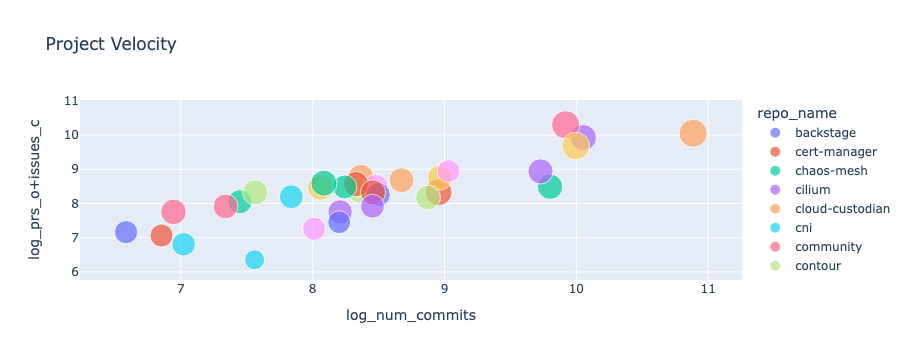

In [45]:
fig.show()

## Application of different strategies

Note: axis will be edited when implemented in dash as well as the ability to use a date range slider 

### 1: Y axis Total PR and Issues opened 

In [46]:
df_consolidated["prs_open_plus_issues_open"] = df_consolidated["issue_opened"] + df_consolidated["pull_request_open"]
df_consolidated["log_prs_open+issues_open"] = df_consolidated["prs_open_plus_issues_open"].apply(math.log)

Visualization with logs

In [47]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="log_prs_open+issues_open", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

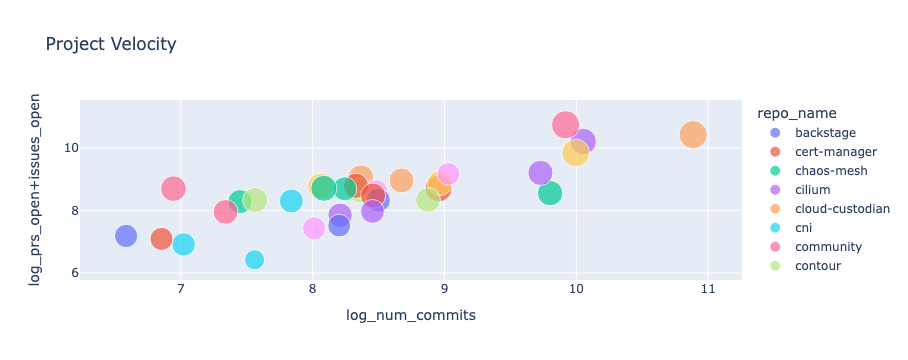

In [48]:
fig.show()

Visualization of raw values for y axis

In [49]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="prs_open_plus_issues_open", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

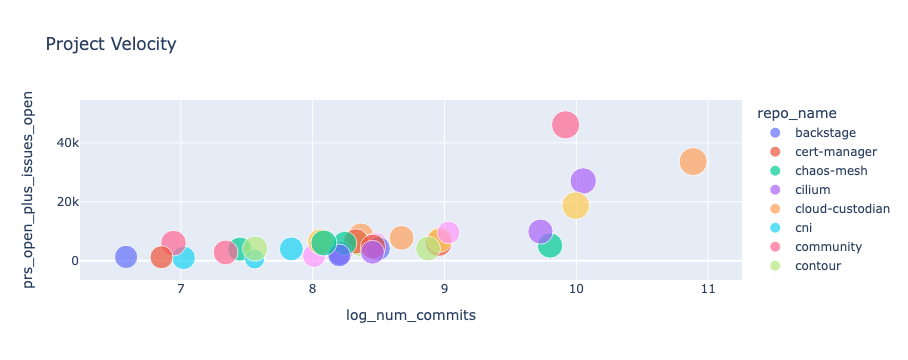

In [50]:
fig.show()

### 2: PR and issue actions

PR: open, closed, merged <br>
Issues: open , closed

In [51]:
df_consolidated["prs_issues_actions"] = (df_consolidated["issue_opened"] + 
df_consolidated["issue_closed"] + df_consolidated["pull_request_open"] + df_consolidated["pull_request_merged"] + 
df_consolidated["pull_request_closed"])
df_consolidated["log_prs_issues_actions"] = df_consolidated["prs_issues_actions"].apply(math.log)

In [52]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="log_prs_issues_actions", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

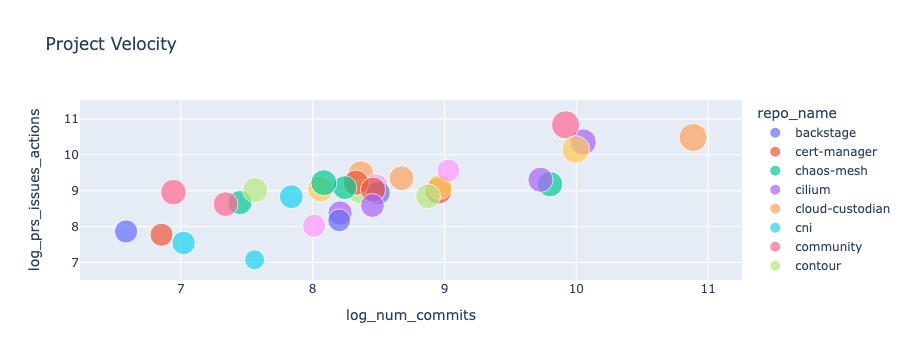

In [53]:
fig.show()

Visualization of raw values for y axis

In [54]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="prs_issues_actions", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

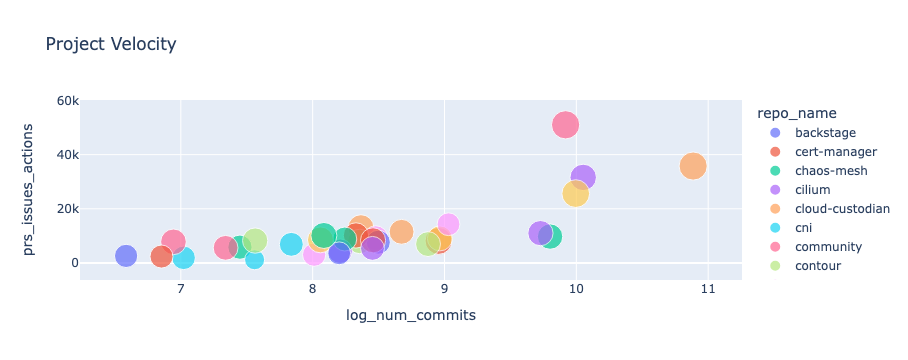

In [55]:
fig.show()

### 3: PR and Issues actions with weights 
PR: open, closed, merged <br>
Issues: open , closed

Note: these weights to be workshoped if this stategy is choosen, the weights in relation to each other is most important 

In [56]:
i_o_weight = .3
i_c_weight = .4
pr_o_weight = .5
pr_m_weight = .7
pr_c_weight = .2

In [57]:
df_consolidated["prs_issues_actions_weighted"] = (df_consolidated["issue_opened"]*i_o_weight + 
df_consolidated["issue_closed"]*i_c_weight + df_consolidated["pull_request_open"]*pr_o_weight
+ df_consolidated["pull_request_merged"]*pr_m_weight + df_consolidated["pull_request_closed"]*pr_c_weight)
df_consolidated["log_prs_issues_actions_weighted"] = df_consolidated["prs_issues_actions"].apply(math.log)

Visualization of log values for y axis 

In [58]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="log_prs_issues_actions_weighted", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

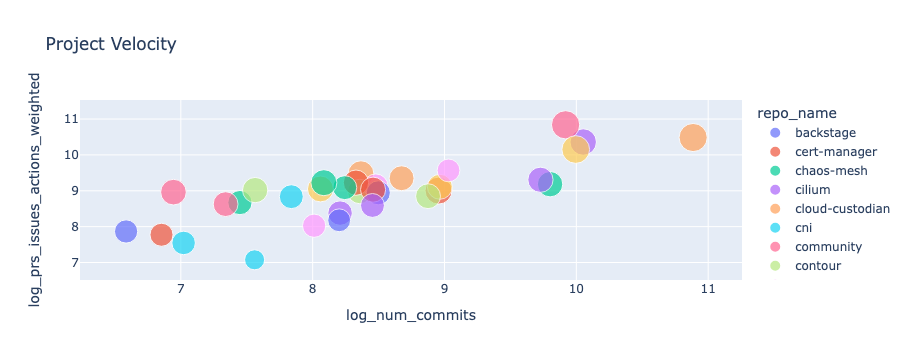

In [59]:
fig.show()

Visualization of raw values

In [60]:
fig = px.scatter(df_consolidated, 
                 x="log_num_commits", 
                 y="prs_issues_actions_weighted", 
                 color="repo_name",
                 size='log_num_contrib', 
                 hover_data=['repo_name'],
                 title="Project Velocity")

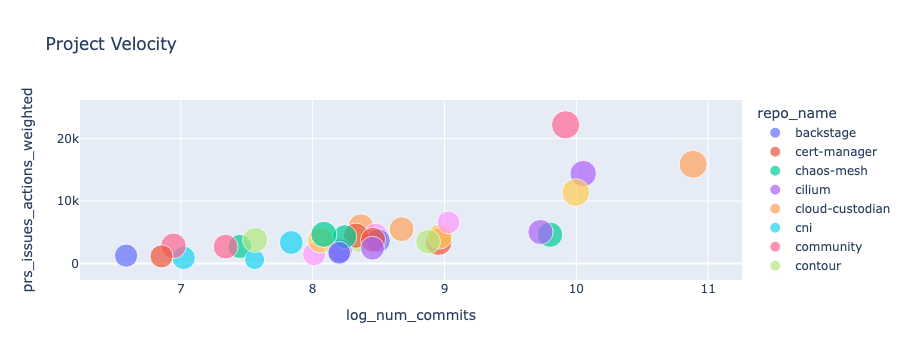

In [61]:
fig.show()